# AutoEncoder model 

### Loading the dataset

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import numpy as np

In [17]:
def multiple_plotting(str1, str2, str3, str4):
    # 파일 경로, 이름 설정해주세요.
    data1_df = pd.read_csv(str1, header=None)
    data2_df = pd.read_csv(str2, header=None)
    data3_df = pd.read_csv(str3, header=None)
    data4_df = pd.read_csv(str4, header=None)

    data1_df.columns = ['x', 'y', 'z']
    data2_df.columns = ['x', 'y', 'z']
    data3_df.columns = ['x', 'y', 'z']
    data4_df.columns = ['x', 'y', 'z']


    vector_value1 = np.sqrt(data1_df['x']** 2 + data1_df['y']**2 + data1_df['z']**2)
    vector_value2 = np.sqrt(data2_df['x']** 2 + data2_df['y']**2 + data2_df['z']**2)
    vector_value3 = np.sqrt(data3_df['x']** 2 + data3_df['y']**2 + data3_df['z']**2)
    vector_value4 = np.sqrt(data4_df['x']** 2 + data4_df['y']**2 + data4_df['z']**2)

    plt.figure(figsize=(20,20))
    fig, axes = plt.subplots(nrows=2, ncols=2)

    axes[0][0].plot(vector_value1)
    axes[0][1].plot(vector_value2)
    axes[1][0].plot(vector_value3)
    axes[1][1].plot(vector_value4)

    for ax in axes.flatten():
        ax.set_ylim(0.6, 1.4)
    plt.show()

<Figure size 2000x2000 with 0 Axes>

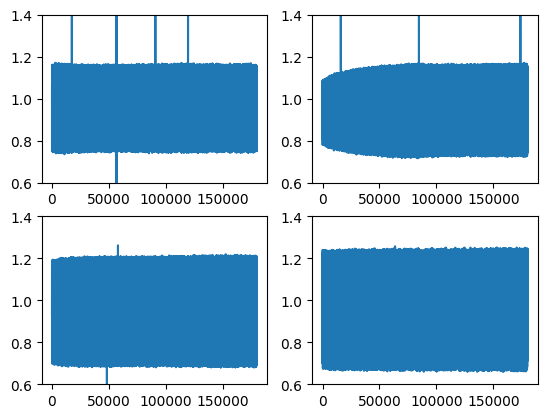

In [4]:
multiple_plotting()

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


In [33]:
data1_df = pd.read_csv('data/normal_9v_data.csv', header=None)
data2_df = pd.read_csv('data/normal_10v_data.csv', header=None)
data3_df = pd.read_csv('data/normal_11v_data.csv', header=None)
data4_df = pd.read_csv('data/normal_12v_data.csv', header=None)

data1_df = scaler.fit_transform(data1_df)
data2_df = scaler.fit_transform(data2_df)
data3_df = scaler.fit_transform(data3_df)
data4_df = scaler.fit_transform(data4_df)

print(data1_df.shape)
# combined_df = pd.concat([data1_df, data2_df, data3_df, data4_df], ignore_index=True)
# print(combined_df.shape)

(180000, 3)


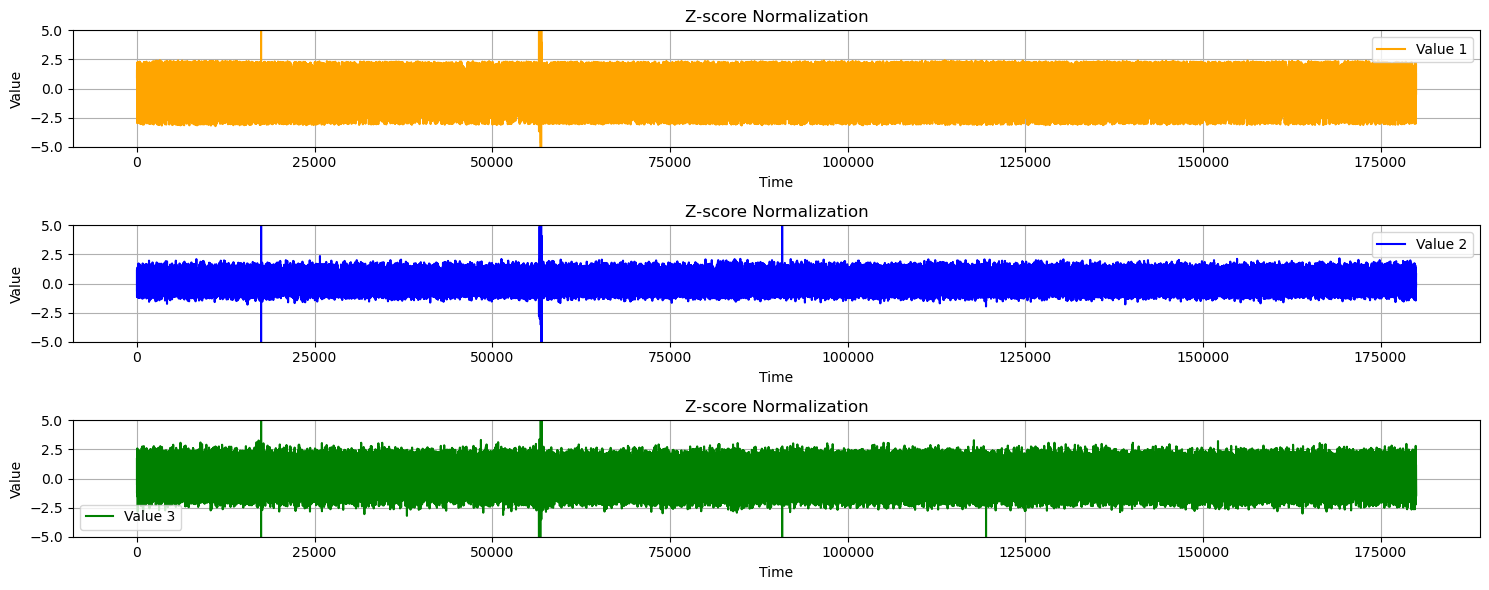

In [47]:
# 시각화
time = np.arange(data1_df.shape[0])  
plt.figure(figsize=(15, 6))

plt.subplot(3, 1, 1) 
plt.plot(time, data1_df[:, 0], color='orange', label='Value 1')
# plt.plot(time, data1_df[:, 1], color='blue', label='Value 2')
# plt.plot(time, data1_df[:, 2], color='green', label='Value 3')

plt.title('Z-score Normalization')
plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim(-5, 5)
plt.grid()
plt.legend()


plt.subplot(3, 1, 2) 
# plt.plot(time, data1_df[:, 0], color='orange', label='Value 1')
plt.plot(time, data1_df[:, 1], color='blue', label='Value 2')
# plt.plot(time, data1_df[:, 2], color='green', label='Value 3')

plt.title('Z-score Normalization')
plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim(-5, 5)
plt.grid()
plt.legend()


plt.subplot(3, 1, 3) 
# plt.plot(time, data1_df[:, 0], color='orange', label='Value 1')
# plt.plot(time, data1_df[:, 1], color='blue', label='Value 2')
plt.plot(time, data1_df[:, 2], color='green', label='Value 3')

plt.title('Z-score Normalization')
plt.xlabel('Time')
plt.ylabel('Value')
plt.ylim(-5, 5)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
train_ratio = 0.7
temp_ratio = 0.3  # for both val and test combined
val_ratio = 0.5  # 50% of temp_ratio for validation
test_ratio = temp_ratio / 2  # same as val_ratio

data4_df = data4_df[:len(data4_df) - (len(data4_df) % 100)]
# data4_df = data4_df[:-558]
print(len(data1_df), len(data2_df), len(data3_df), len(data4_df))

data_split_0 = np.array_split(data1_df, len(data1_df) // 100)
data_split_1 = np.array_split(data2_df, len(data2_df) // 100)
data_split_2 = np.array_split(data3_df, len(data3_df) // 100)
data_split_3 = np.array_split(data4_df, len(data4_df) // 100)

data_splits = [data_split_0, data_split_1, data_split_2, data_split_3]

train_sizes = []
train_data = []
val_data = []
test_data = []

for i in range(4):
    data_len = len(data_splits[i])
    train_size = int(data_len * train_ratio)
    temp_size = data_len - train_size 
    val_size = int(temp_size * val_ratio)
    
    # Split the data
    train_sizes.append(train_size)
    train_data.append(data_splits[i][:train_size])
    val_data.append(data_splits[i][train_size:train_size + val_size])
    test_data.append(data_splits[i][train_size + val_size:])

# check the lengths of each split
for i in range(4):
    print(f"Data split {i}: train + val + test =", len(train_data[i]), "+", len(val_data[i]), "+", len(test_data[i]))
    print(len(train_data[i][0]), len(val_data[i][0]),  len(test_data[i][0]))

# Concatenate all splits across the 4 data parts
x_train_concat = np.concatenate(train_data, axis=0)
x_val_concat = np.concatenate(val_data, axis=0)
x_test_concat = np.concatenate(test_data, axis=0)

# x_train_concat = pd.concat(train_data, ignore_index=True)
# x_val_concat = pd.concat(val_data, ignore_index=True)
# x_test_concat = pd.concat(test_data, ignore_index=True)

# Output final shapes to confirm correct splitting
print("Train data shape:", x_train_concat.shape)
print("Validation data shape:", x_val_concat.shape)
print("Test data shape:", x_test_concat.shape)



180000 180000 180000 180500
Data split 0: train + val + test = 1260 + 270 + 270
100 100 100
Data split 1: train + val + test = 1260 + 270 + 270
100 100 100
Data split 2: train + val + test = 1260 + 270 + 270
100 100 100
Data split 3: train + val + test = 1263 + 271 + 271
100 100 100
Train data shape: (5043, 100, 3)
Validation data shape: (1081, 100, 3)
Test data shape: (1081, 100, 3)


In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D

In [28]:


# 데이터 예시
input_shape = (100, 3)  # 1D 데이터의 형태 (예: 1000개의 시간 포인트)

# 인코더
input_layer = Input(shape=input_shape)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2, padding='same')(x)

x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(pool_size=2, padding='same')(x)

# 디코더
x = UpSampling1D(size=2)(encoded)
x = Conv1D(16, kernel_size=3, activation='relu', padding='same')(x)

x = UpSampling1D(size=2)(x)
decoded = Conv1D(3, kernel_size=3, activation='sigmoid', padding='same')(x)

# 모델 생성
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')





Epoch 1/20
158/158 [==============================] - 1s 7ms/step - loss: 0.0738 - val_loss: 0.0045
Epoch 2/20
158/158 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 3/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 4/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 5/20
158/158 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 6/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 7/20
158/158 [==============================] - 1s 6ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 8/20
158/158 [==============================] - 1s 6ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 9/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 10/20
158/158 [==============================] - 1s 5ms/step - loss: 0.0040 - val_loss: 0.0039

In [98]:
from tensorflow.keras import layers, models
from keras.optimizers import Adam




def autoencoder_model(input_shape=(100, 3)):
    inputs = layers.Input(input_shape)

    # Encoder (downsampling path)
    conv1 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(2)(conv1)

    conv2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling1D(2)(conv2)

    conv3 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(conv3)

    conv4 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling1D(pool_size=2)(conv4)

    # Bottleneck
    conv5 = layers.Conv1D(512,  kernel_size=3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv1D(512,  kernel_size=3, activation='relu', padding='same')(conv5)

    # Decoder (upsampling path)
    up6 = layers.Conv1DTranspose(256, kernel_size=2, strides=2, padding='same')(conv5)
    
    conv6 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv1DTranspose(128, kernel_size=2, strides=2, padding='same')(conv6)
    up7 = layers.ZeroPadding1D(padding=(1, 0))(up7)
    print(up7.shape, conv3.shape)

    conv7 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv1DTranspose(64, kernel_size=2, strides=2, padding='same')(conv7)
    

    conv8 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(conv8)
    print(up8.shape, conv8.shape)

    up9 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(conv8)

    conv9 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(conv9)
    
    outputs = layers.Dense(3, activation='linear')(conv9)
    print(outputs.shape, conv9.shape)
    # Model compilation

    # 학습률을 0.001로 설정
    optimizer = Adam(learning_rate=0.00001)
    model = models.Model(inputs=[inputs], outputs=outputs)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# Instantiate and view the model summary
model = autoencoder_model()
model.summary()

(None, 25, 128) (None, 25, 128)
(None, 50, 64) (None, 50, 64)
(None, 100, 3) (None, 100, 32)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 100, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_99 (Conv1D)              │ (None, 100, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_100 (Conv1D)             │ (None, 100, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_101 (Conv1D)             │ (None, 50, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_102 (Conv1D)             │ (None, 50, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_103 (Conv1D)             │ (None, 25, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_104 (Conv1D)             │ (None, 25, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_105 (Conv1D)             │ (None, 12, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_106 (Conv1D)             │ (None, 12, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, 6, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_107 (Conv1D)             │ (None, 6, 512)         │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_108 (Conv1D)             │ (None, 6, 512)         │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_16             │ (None, 12, 256)        │       262,400 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_109 (Conv1D)             │ (None, 12, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_110 (Conv1D)             │ (None, 12, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_17             │ (None, 24, 128)        │        65,664 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d_4                │ (None, 25, 128)        │             0 │
│ (ZeroPadding1D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_111 (Conv1D)             │ (None, 25, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_112 (Conv1D)             │ (None, 25, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_18             │ (None, 50, 64)         │        16,448 │
│ (Conv1DTranspose)               │                        │             

 Total params: 2,444,003 (9.32 MB)

 Trainable params: 2,444,003 (9.32 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# 오토인코더 모델 정의
def create_autoencoder(input_shape):
    input_layer = layers.Input(shape=input_shape)

    # 인코더
    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)
    x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2, padding='same')(x)

    # 디코더
    x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)
    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(size=2)(x)

    # output_layer = layers.Conv1D(filters=3, kernel_size=3, activation='sigmoid', padding='same')(x)
    output_layer = layers.Dense(3, activation='linear')(x)

    autoencoder = models.Model(input_layer, output_layer)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

input_shape = (100, 3)  # 시퀀스 길이 96, 특성 수 3 (x, y, z)
autoencoder = create_autoencoder(input_shape)

# 모델 학습
# autoencoder.fit(x_train_concat, x_train_concat, epochs=50, batch_size=32, validation_split=0.2)

# # 어노말리 탐지 예시
# reconstructed_data = autoencoder.predict(data)
# mse = np.mean(np.square(data - reconstructed_data), axis=(1, 2))  # MSE 계산
# threshold = np.percentile(mse, 95)  # 95th percentile을 임계값으로 설정

# # 어노말리 탐지
# anomalies = mse > threshold
# print("Detected anomalies:", anomalies)

In [107]:
from tensorflow.keras import layers, models
from keras.optimizers import Adam




def autoencoder_model(input_shape=(100, 3)):
    inputs = layers.Input(input_shape)

    # Encoder (downsampling path)
    conv1 = layers.Conv1D(256, kernel_size=3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv1D(256, kernel_size=3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(2)(conv1)

    conv2 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling1D(2)(conv2)

    conv3 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(conv3)

    conv4 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling1D(pool_size=2)(conv4)


    # Decoder (upsampling path)
    up6 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(pool4)
    
    conv6 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv1D(32,  kernel_size=3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv1DTranspose(64, kernel_size=2, strides=2, padding='same')(conv6)
    up7 = layers.ZeroPadding1D(padding=(1, 0))(up7)
    print(up7.shape, conv3.shape)

    conv7 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv1D(64,  kernel_size=3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv1DTranspose(128, kernel_size=2, strides=2, padding='same')(conv7)
    

    conv8 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')(conv8)
    print(up8.shape, conv8.shape)

    up9 = layers.Conv1DTranspose(256, kernel_size=2, strides=2, padding='same')(conv8)

    conv9 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv1D(256,  kernel_size=3, activation='relu', padding='same')(conv9)
    
    outputs = layers.Dense(3, activation='linear')(conv9)
    print(outputs.shape, conv9.shape)
    # Model compilation

    # 학습률을 0.001로 설정
    optimizer = Adam(learning_rate=0.00001)
    model = models.Model(inputs=[inputs], outputs=outputs)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# Instantiate and view the model summary
model = autoencoder_model()
model.summary()

(None, 25, 64) (None, 25, 64)
(None, 50, 128) (None, 50, 128)
(None, 100, 3) (None, 100, 256)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 100, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_133 (Conv1D)             │ (None, 100, 256)       │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_134 (Conv1D)             │ (None, 100, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_135 (Conv1D)             │ (None, 50, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_136 (Conv1D)             │ (None, 50, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_137 (Conv1D)             │ (None, 25, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_138 (Conv1D)             │ (None, 25, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_139 (Conv1D)             │ (None, 12, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_140 (Conv1D)             │ (None, 12, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_24             │ (None, 12, 32)         │         2,080 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_141 (Conv1D)             │ (None, 12, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_142 (Conv1D)             │ (None, 12, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_25             │ (None, 24, 64)         │         4,160 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding1d_5                │ (None, 25, 64)         │             0 │
│ (ZeroPadding1D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_143 (Conv1D)             │ (None, 25, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_144 (Conv1D)             │ (None, 25, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_26             │ (None, 50, 128)        │        16,512 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_145 (Conv1D)             │ (None, 50, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_146 (Conv1D)             │ (None, 50, 128)        │        49,28

 Total params: 1,005,923 (3.84 MB)

 Trainable params: 1,005,923 (3.84 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
# 모델 학습
autoencoder.fit(
    x_train_concat, 
    x_train_concat,
    epochs=50, 
    batch_size=64, 
    validation_data = (x_val_concat, x_val_concat),
    verbose = 1,
    shuffle=True
    # validation_split=0.2
    )


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4653 - val_loss: 0.3543
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4160 - val_loss: 0.3548
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3915 - val_loss: 0.3564
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3846 - val_loss: 0.3571
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4483 - val_loss: 0.3546
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5194 - val_loss: 0.3534
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5124 - val_loss: 0.3531
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4728 - val_loss: 0.3534
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4303 - val_loss: 0.3533
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4038 - val_loss: 0.3540
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5079 - val_loss: 0.3548
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4176 - val_lo

In [100]:
autoencoder.save("autoencoder_3.h5")

### Check Anomaly data

<Figure size 2000x2000 with 0 Axes>

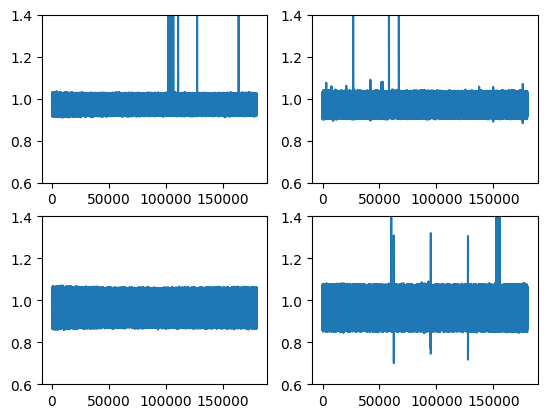

In [8]:
anomaly_data1 = 'data/anomaly_data/anomaly_3v_data1.csv'
anomaly_data2 = 'data/anomaly_data/anomaly_3v_data2.csv'
anomaly_data3 = 'data/anomaly_data/anomaly_5v_data1.csv'
anomaly_data4 = 'data/anomaly_data/anomaly_5v_data2.csv'
multiple_plotting(anomaly_data1, anomaly_data2, anomaly_data3, anomaly_data4)

<Figure size 2000x2000 with 0 Axes>

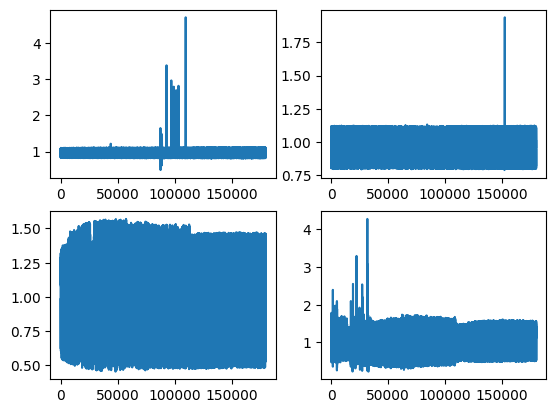

In [13]:
anomaly_data1 = 'data/anomaly_data/anomaly_7v_data1.csv'
anomaly_data2 = 'data/anomaly_data/anomaly_7v_data2.csv'
anomaly_data3 = 'data/anomaly_data/anomaly_contact_9v_data1.csv'
anomaly_data4 = 'data/anomaly_data/anomaly_contact_12v_data1.csv'
multiple_plotting(anomaly_data1, anomaly_data2, anomaly_data3, anomaly_data4)

<Figure size 2000x2000 with 0 Axes>

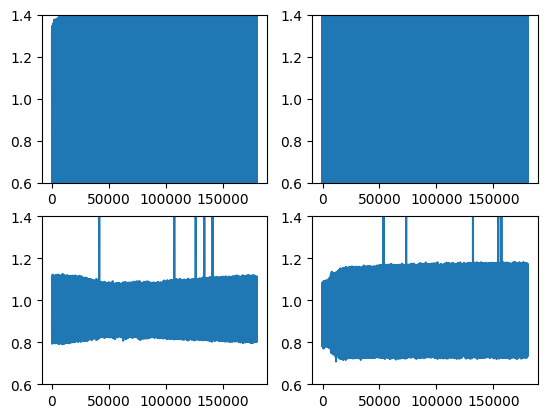

In [18]:

anomaly_data1 = 'data/anomaly_data/anomaly_contact_9v_data1.csv'
anomaly_data2 = 'data/anomaly_data/anomaly_contact_12v_data1.csv'
anomaly_data3 = 'data/anomaly_data/anomaly_unbalanced_9v_data1.csv'
anomaly_data4 = 'data/anomaly_data/anomaly_unbalanced_12v_data1.csv'
multiple_plotting(anomaly_data1, anomaly_data2, anomaly_data3, anomaly_data4)

### Anomaly dataset prepration

In [70]:
import os

folder_path = 'data/anomaly_data'

anomaly_data_path = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]

print(anomaly_data_path)


['data/anomaly_data/anomaly_7v_data2.csv', 'data/anomaly_data/anomaly_7v_data1.csv', 'data/anomaly_data/anomaly_5v_data2.csv', 'data/anomaly_data/anomaly_5v_data1.csv', 'data/anomaly_data/anomaly_unbalanced_9v_data1.csv', 'data/anomaly_data/anomaly_3v_data1.csv', 'data/anomaly_data/anomaly_3v_data2.csv', 'data/anomaly_data/anomaly_unbalanced_12v_data1.csv', 'data/anomaly_data/anomaly_contact_12v_data1.csv', 'data/anomaly_data/anomaly_contact_9v_data1.csv']


### Test with just anomaly data

In [109]:
all_anomaly_test_data = []
for data in anomaly_data_path:
    df = pd.read_csv(data)
    df = scaler.fit_transform(df)
    df = df[:len(df) - (len(df) % 100)]
    all_anomaly_test_data.append(df.reshape(-1, 100, 3))
    # print(df.shape)

# all_anomaly_test_data = np.concatenate(all_anomaly_test_data, axis=0)
for i in range(len(all_anomaly_test_data)):
    print(all_anomaly_test_data[i].shape)


(1800, 100, 3)
(1799, 100, 3)
(1800, 100, 3)
(1800, 100, 3)
(1800, 100, 3)
(1800, 100, 3)
(1800, 100, 3)
(1800, 100, 3)
(1799, 100, 3)
(1799, 100, 3)


In [61]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [111]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

autoencoder = load_model("autoencoder.h5")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


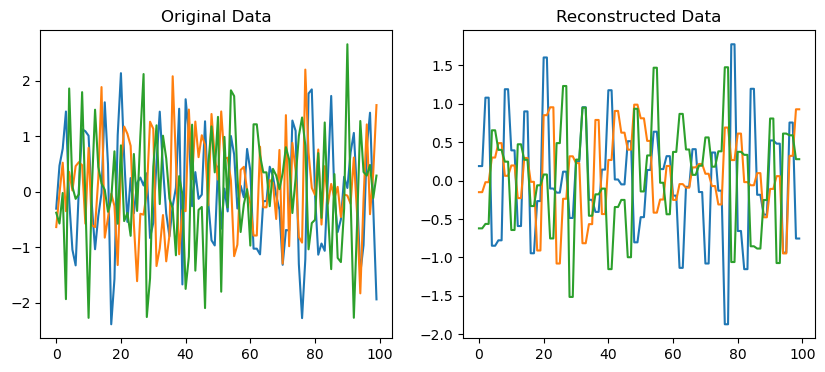

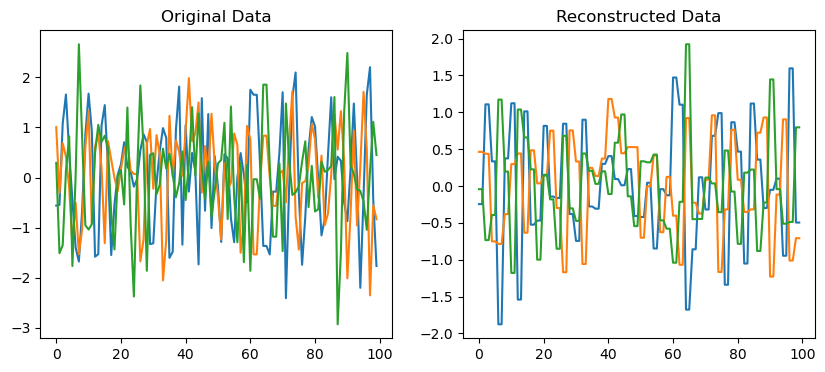

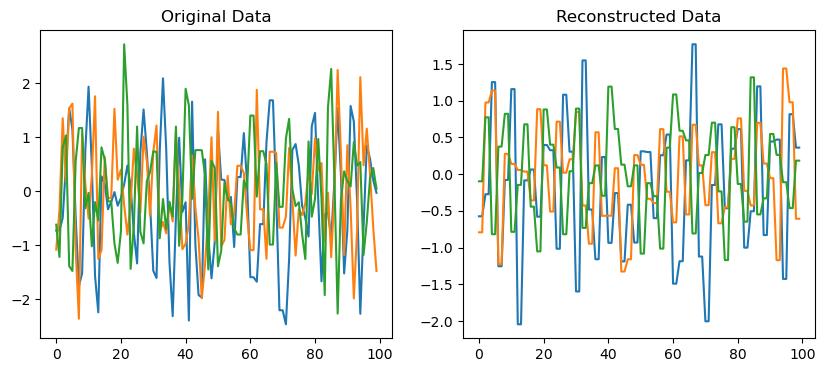

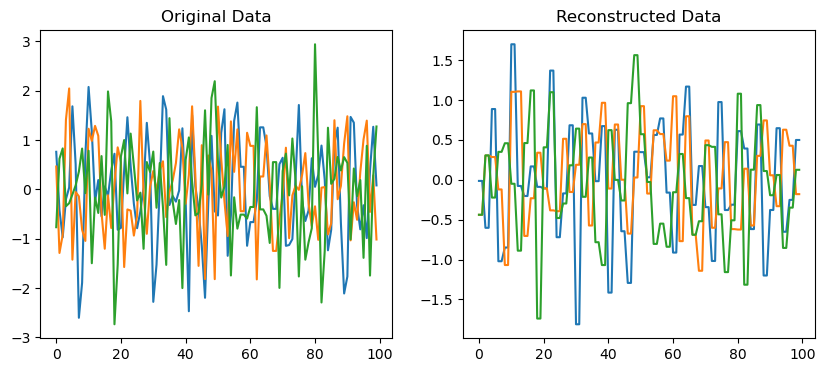

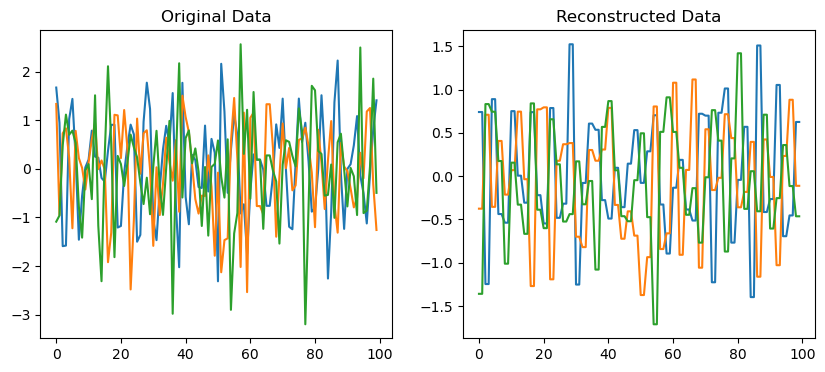

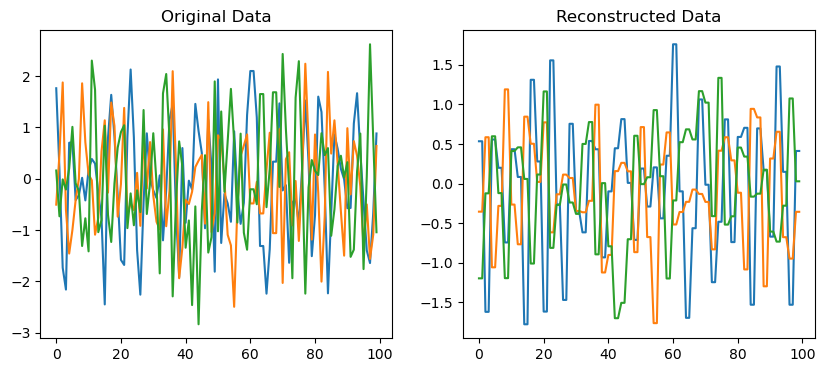

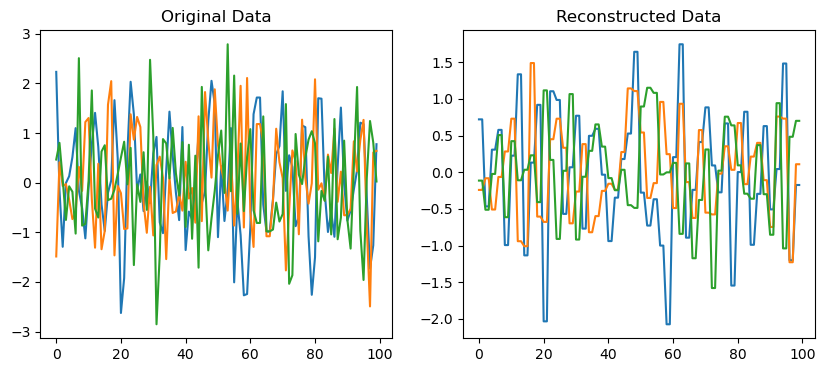

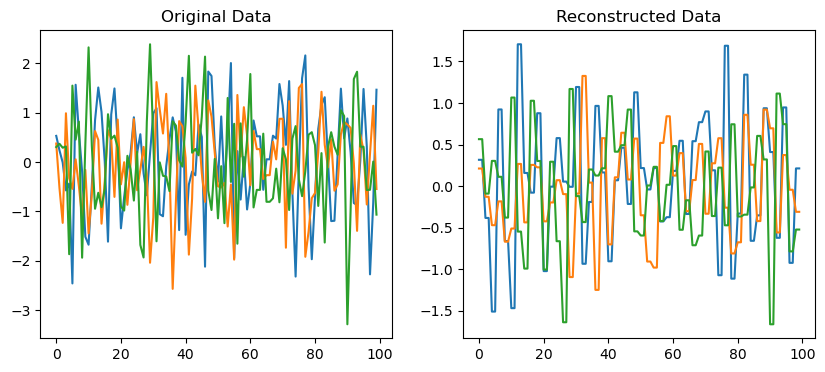

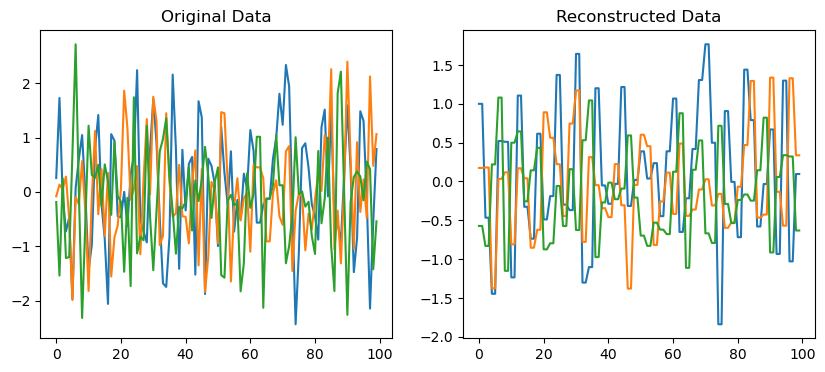

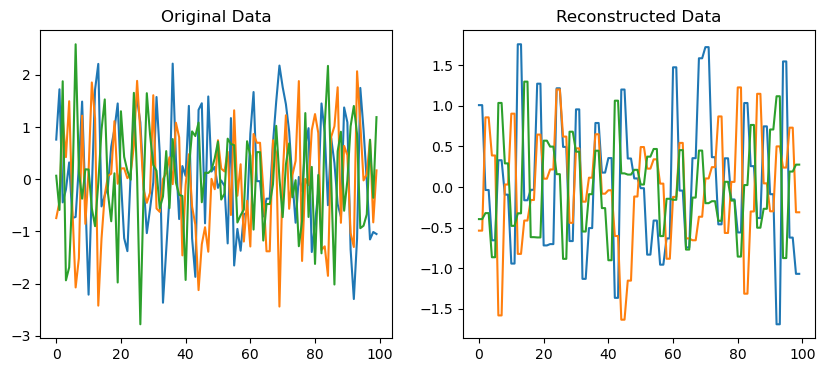

In [110]:
# 비정상 데이터 확인
reconstructed_data = autoencoder.predict(all_anomaly_test_data[-1])

# 4. 결과 분석
# 원본 데이터와 재구성된 데이터 비교
for i in range(10):  # 첫 5개 샘플만 비교
    plt.figure(figsize=(10, 4))
    
    # 원본 데이터
    plt.subplot(1, 2, 1)
    plt.title("Original Data")
    plt.plot(all_anomaly_test_data[-1][-i-1].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화
    
    # 재구성된 데이터
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Data")
    plt.plot(reconstructed_data[-i-1].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화

    plt.show()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


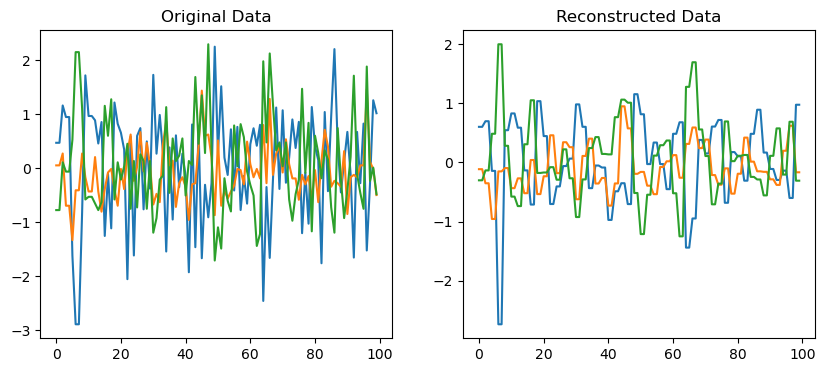

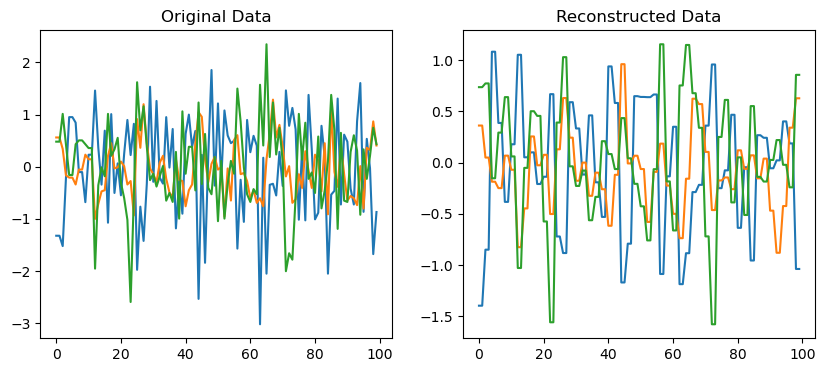

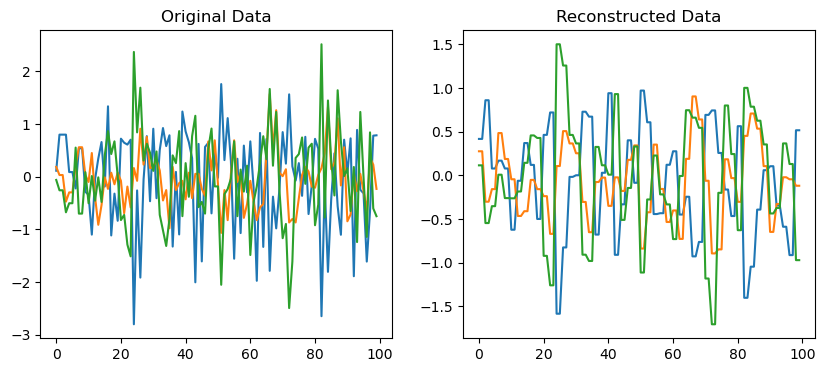

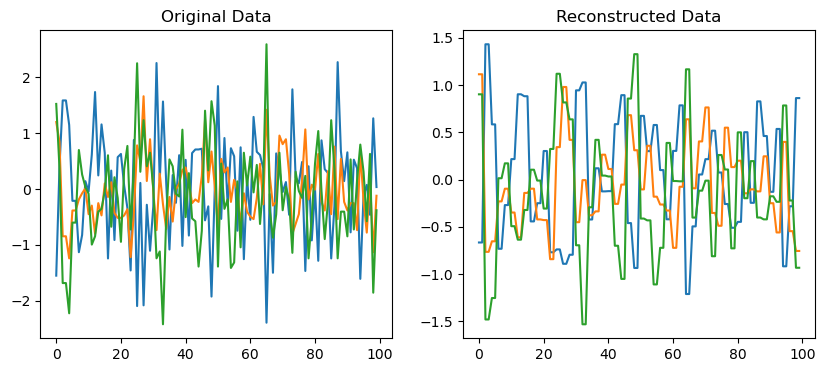

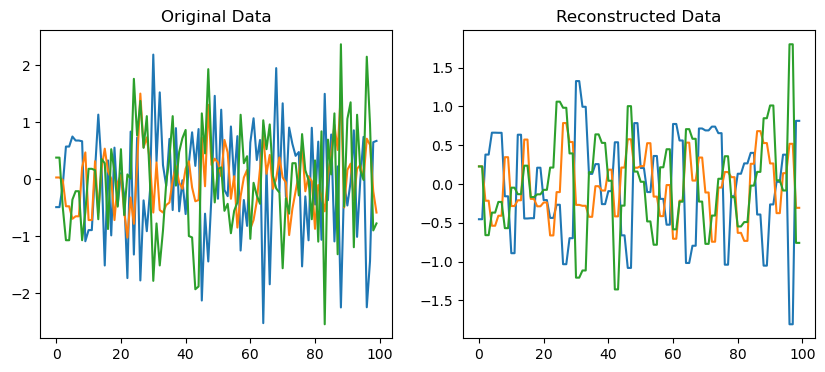

In [94]:
# 정상 데이터 확인
reconstructed_data = autoencoder.predict(x_test_concat)
reconstruction_error = np.mean(np.square(x_test_concat - reconstructed_data), axis=1)
# 4. 결과 분석
# 원본 데이터와 재구성된 데이터 비교
for i in range(5):  # 첫 5개 샘플만 비교
    plt.figure(figsize=(10, 4))
    
    # 원본 데이터
    plt.subplot(1, 2, 1)
    plt.title("Original Data")
    plt.plot(x_test_concat[i].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화
    
    # 재구성된 데이터
    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Data")
    plt.plot(reconstructed_data[i].reshape(-1, 3))  # 데이터를 2D로 변형하여 시각화

    plt.show()

In [104]:
reconstructed_data = autoencoder.predict(x_test_concat)
reconstruction_error = np.mean(np.square(x_test_concat - reconstructed_data), axis=1)



print(np.isnan(reconstruction_error).any())  # True면 NaN이 포함되어 있음
nan_count = np.sum(np.isnan(reconstruction_error)) 
reconstruction_error = np.nan_to_num(reconstruction_error)

mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)

print(mean_error, std_error)

# threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차

# mean_error = np.mean(reconstruction_error)
# std_error = np.std(reconstruction_error)
threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차

# threshold = np.percentile(reconstruction_error, 95) 
# print(threshold)
is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축


# is_anomaly = reconstruction_error > threshold
is_anomaly = is_anomaly_x | is_anomaly_y | is_anomaly_z

anomaly_count = np.sum(is_anomaly)  # True의 개수
normal_count = len(is_anomaly) - anomaly_count  # False의 개수

# 비율 계산
total_count = len(is_anomaly)
anomaly_ratio = anomaly_count / total_count
normal_ratio = normal_count / total_count

print(f'어노말리 비율: {anomaly_ratio:.2%}')
print(f'정상 비율: {normal_ratio:.2%}')

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step
True
0.46506506858098695 5.483240615363792
어노말리 비율: 0.09%
정상 비율: 99.91%


(1799, 3)


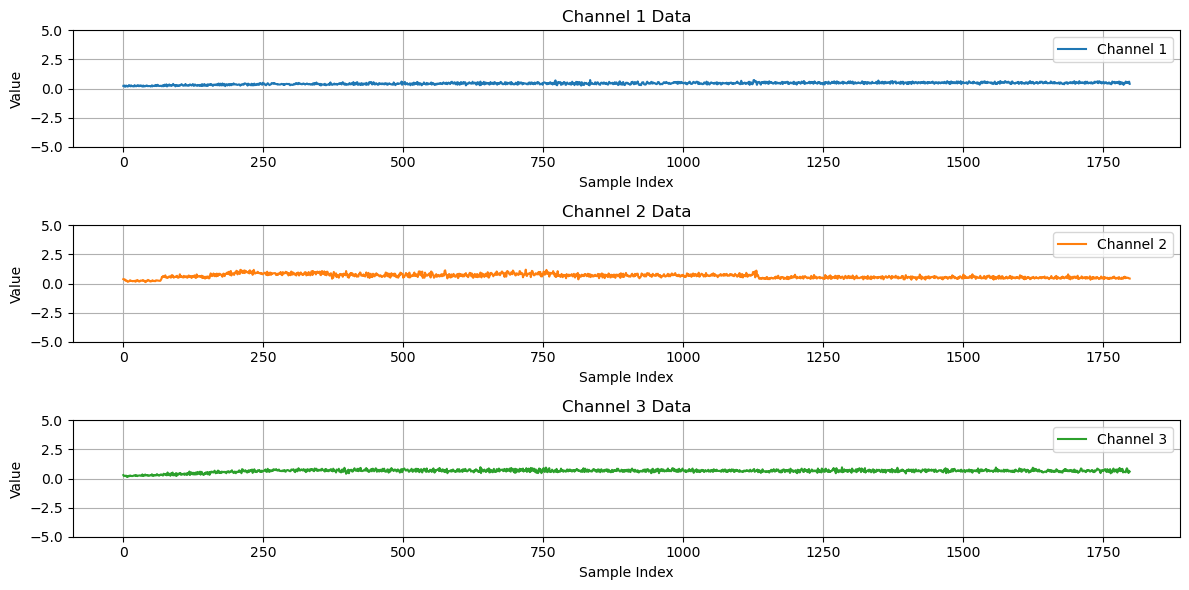

In [103]:
# 정상 데이터 reconstruction error
print(reconstruction_error.shape)

plt.figure(figsize=(12, 6))

# 각 채널에 대해 서브플롯 생성
for i in range(3):
    plt.subplot(3, 1, i + 1)  # 3행 1열의 서브플롯 설정
    plt.plot(reconstruction_error[:, i], label=f'Channel {i + 1}', color=f'C{i}')  # 채널별 그래프
    plt.title(f'Channel {i + 1} Data')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.ylim(-5, 5)
    plt.legend()
    plt.grid()

plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

In [81]:
reconstructed_data = autoencoder.predict(all_anomaly_test_data[-1])
reconstruction_error = np.mean(np.square(all_anomaly_test_data[-1] - reconstructed_data), axis=1)

mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)
threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차
threshold = np.percentile(reconstruction_error, 95) 

is_anomaly = reconstruction_error > threshold
print(is_anomaly)

anomaly_count = np.sum(is_anomaly)  # True의 개수
normal_count = len(is_anomaly) - anomaly_count  # False의 개수

# 비율 계산
total_count = len(is_anomaly)
anomaly_ratio = anomaly_count / total_count
normal_ratio = normal_count / total_count

print(f'어노말리 비율: {anomaly_ratio:.2%}')
print(f'정상 비율: {normal_ratio:.2%}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
[[False False False]
 [False False False]
 [False False False]
 ...
 [ True False False]
 [False False False]
 [False False False]]
어노말리 비율: 15.01%
정상 비율: 84.99%


In [115]:
reconstructed_train_data = model.predict(x_train_concat)
reconstruction_error_train = np.mean(np.square(x_train_concat - reconstructed_train_data), axis=1)

threshold = np.percentile(reconstruction_error_train, 95)

print(threshold)

0.25549716585345333


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
0.46506506858098695 5.483240615363792
False
NaN의 개수: 0
어노말리 비율: 0.06%
정상 비율: 99.94%



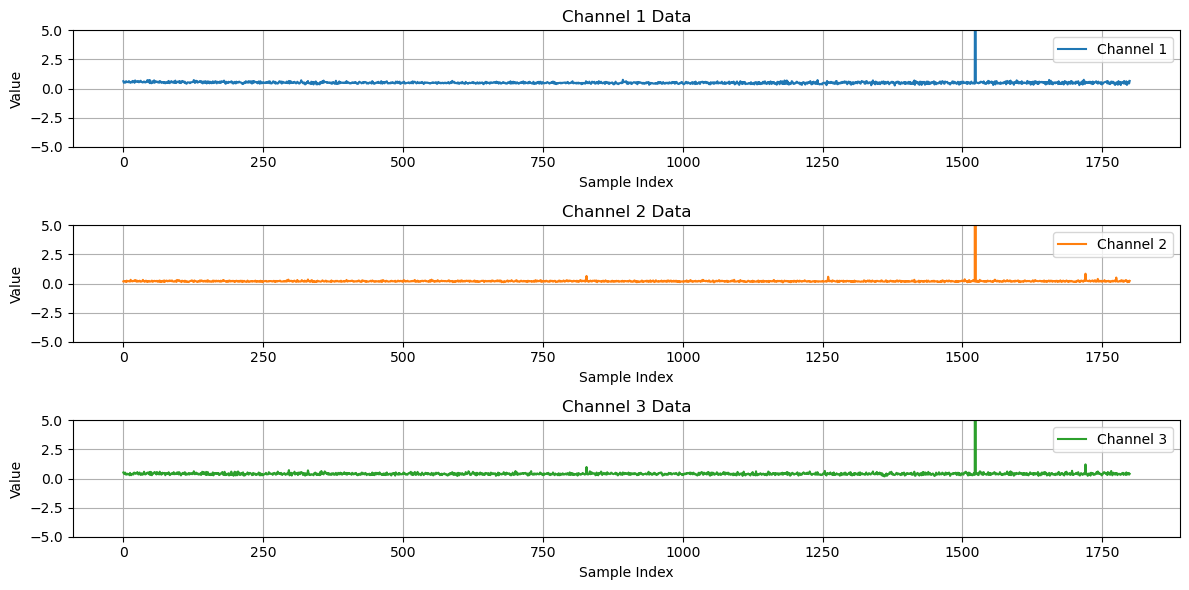

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
0.48687159764430304 7.653158257505856
False
NaN의 개수: 0
어노말리 비율: 0.33%
정상 비율: 99.67%



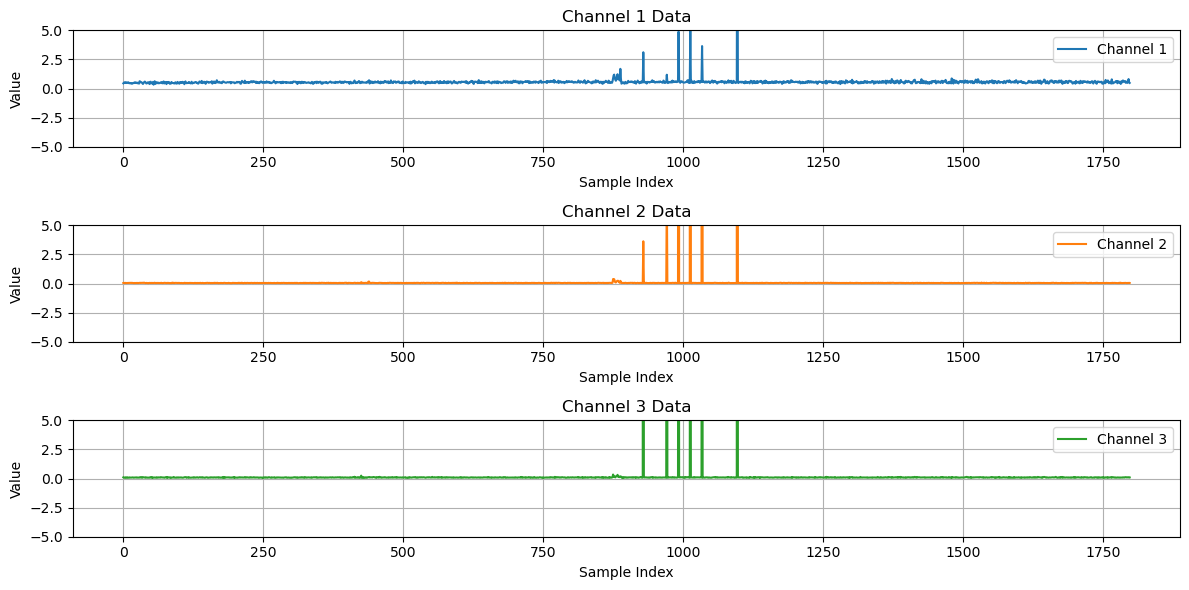

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
0.5612729209319888 9.42121565169932
False
NaN의 개수: 0
어노말리 비율: 0.17%
정상 비율: 99.83%



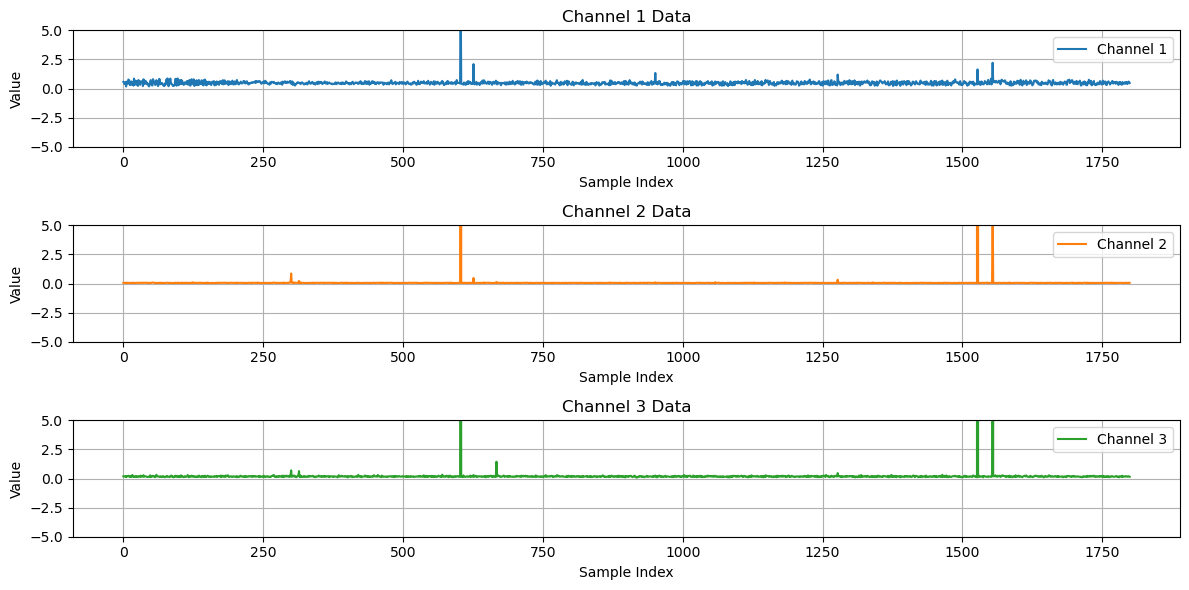

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
0.5155286103543724 10.20531342701532
False
NaN의 개수: 0
어노말리 비율: 9.22%
정상 비율: 90.78%



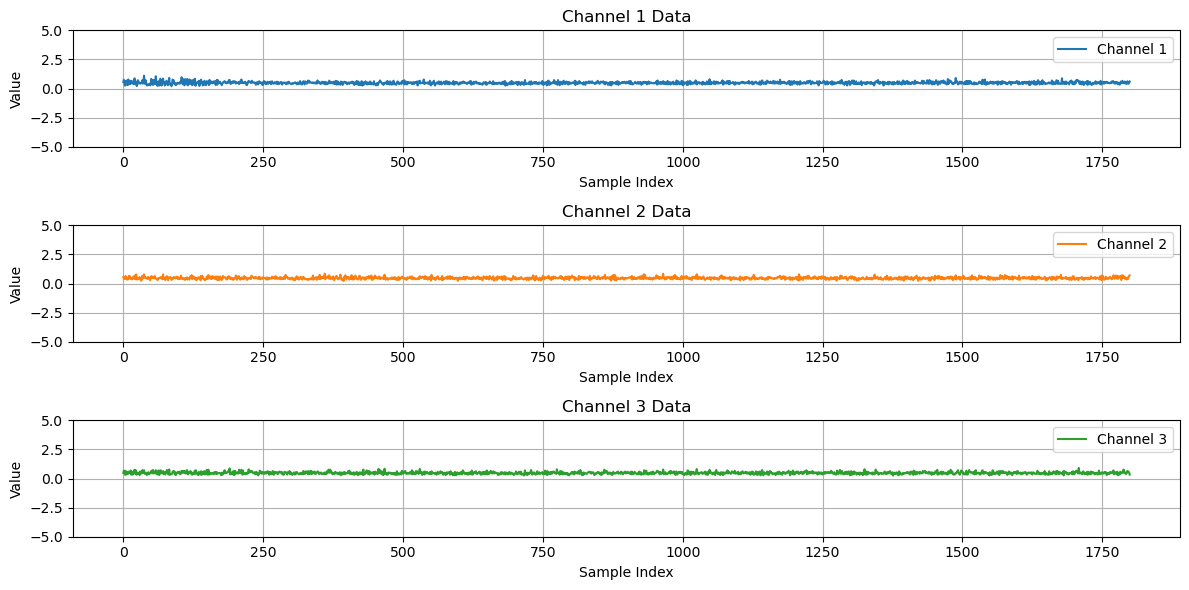

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
0.47833157385408126 0.10104078931346297
True
NaN의 개수: 3
어노말리 비율: 0.28%
정상 비율: 99.72%



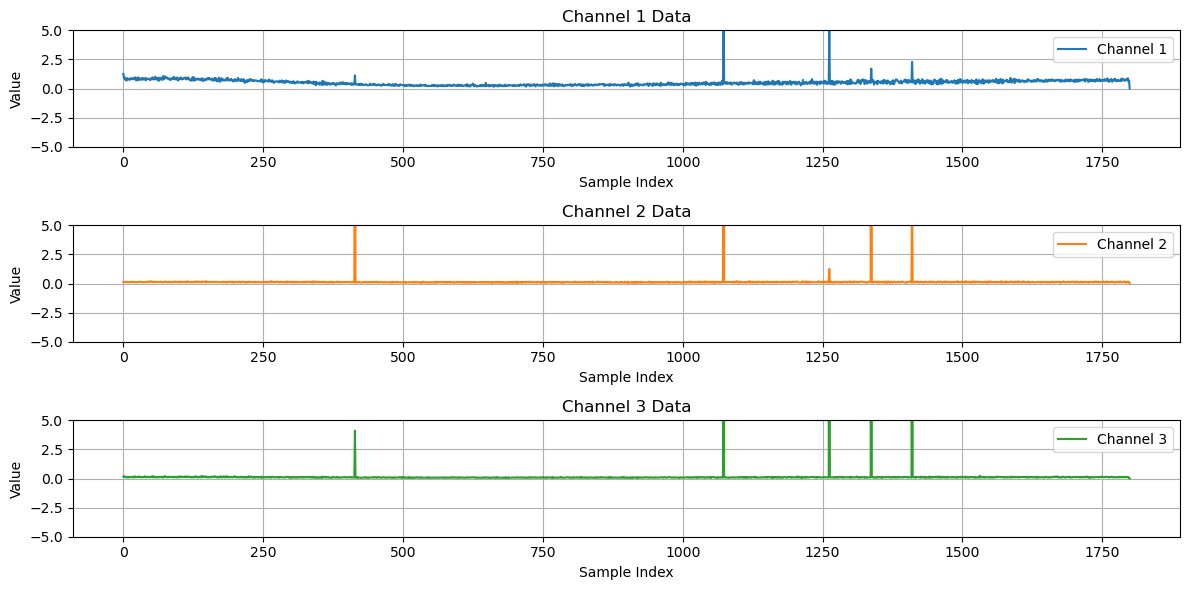

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
0.5111555183136961 8.0470066255559
False
NaN의 개수: 0
어노말리 비율: 0.33%
정상 비율: 99.67%



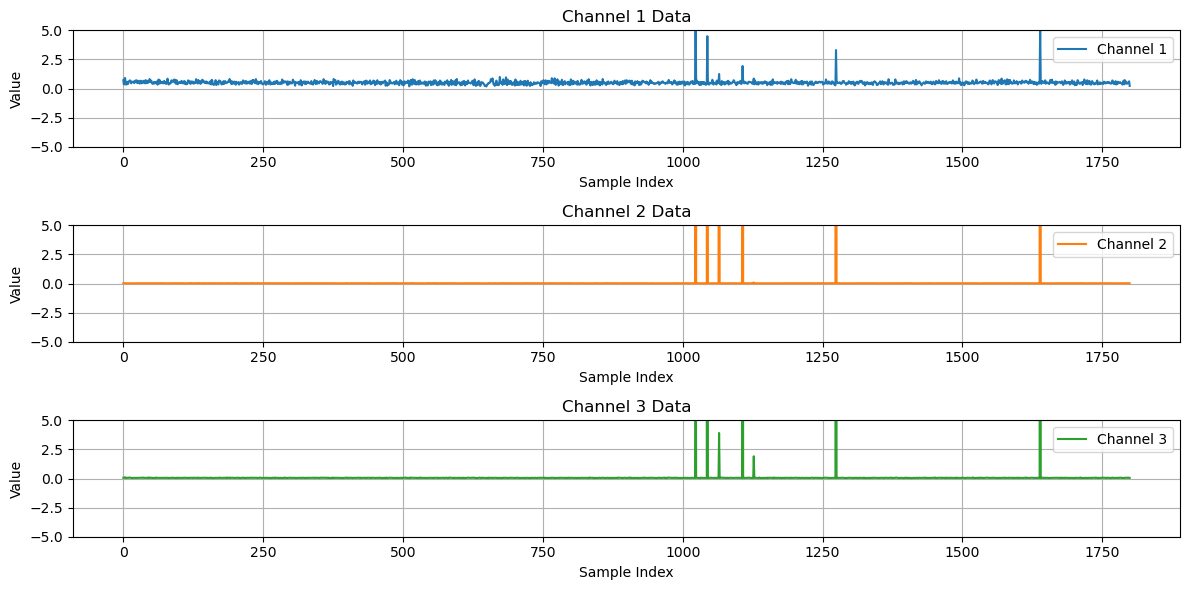

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
0.5398822070333207 9.758184124019445
False
NaN의 개수: 0
어노말리 비율: 0.17%
정상 비율: 99.83%



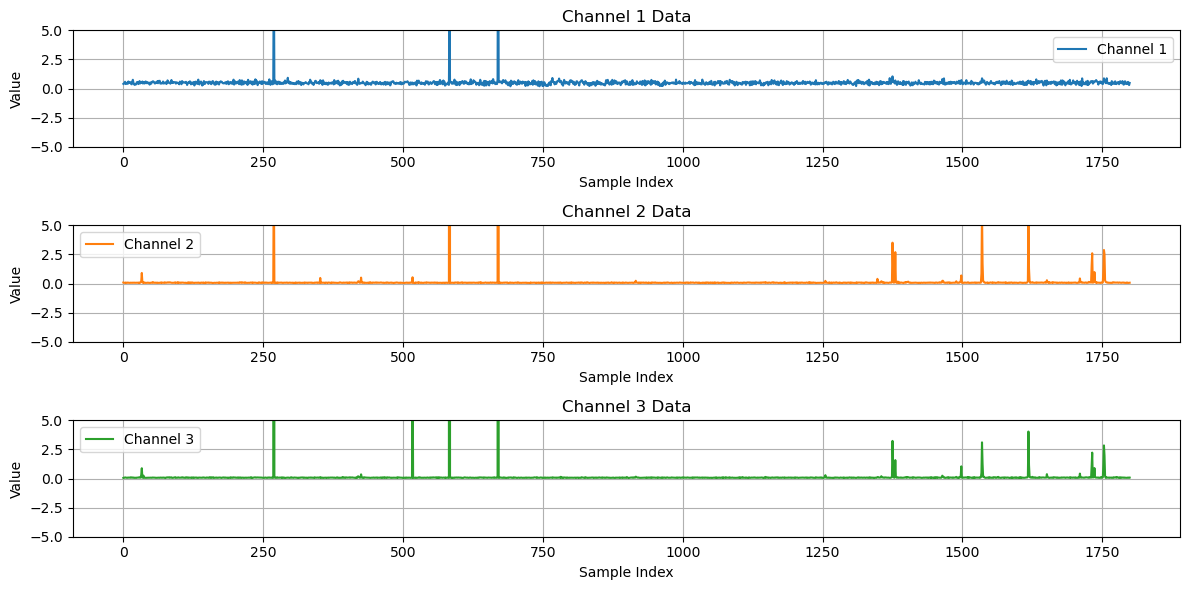

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step
0.50789821243804 10.556860053689903
False
NaN의 개수: 0
어노말리 비율: 0.28%
정상 비율: 99.72%



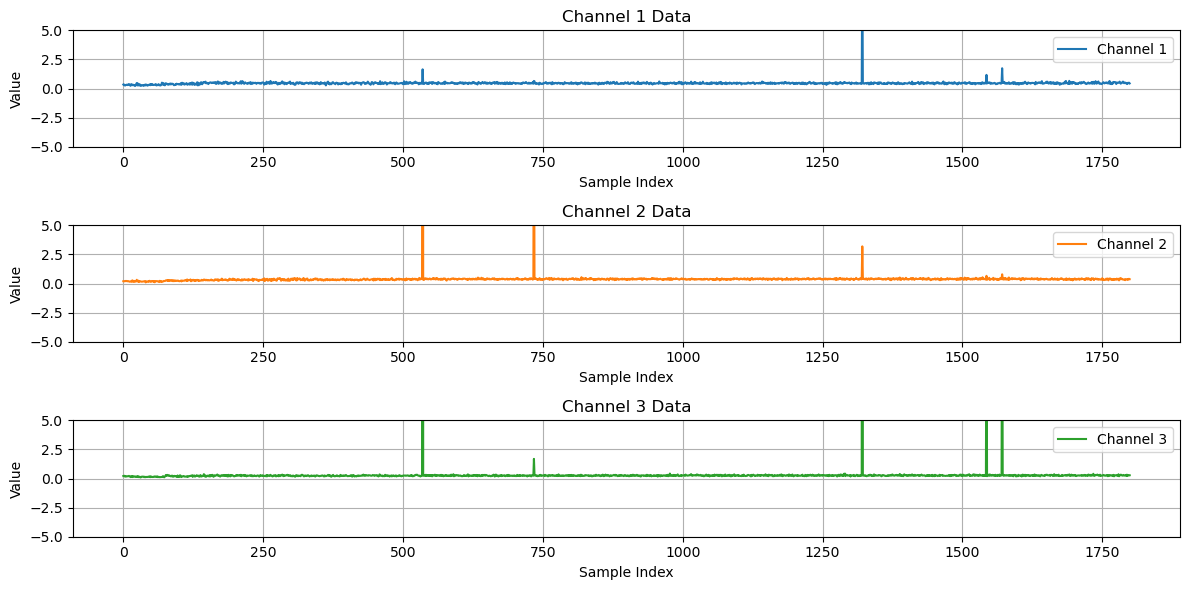

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
0.44470652605511707 3.4027601418665565
False
NaN의 개수: 0
어노말리 비율: 7.28%
정상 비율: 92.72%



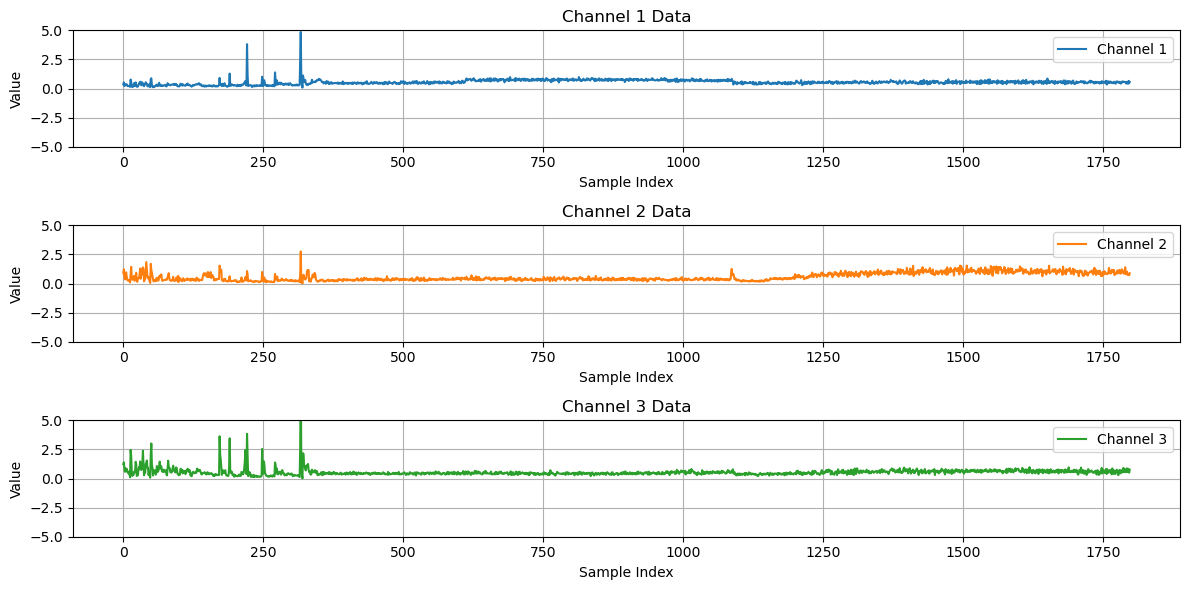

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.5511787129193634 0.30519199917607776
False
NaN의 개수: 0
어노말리 비율: 7.73%
정상 비율: 92.27%



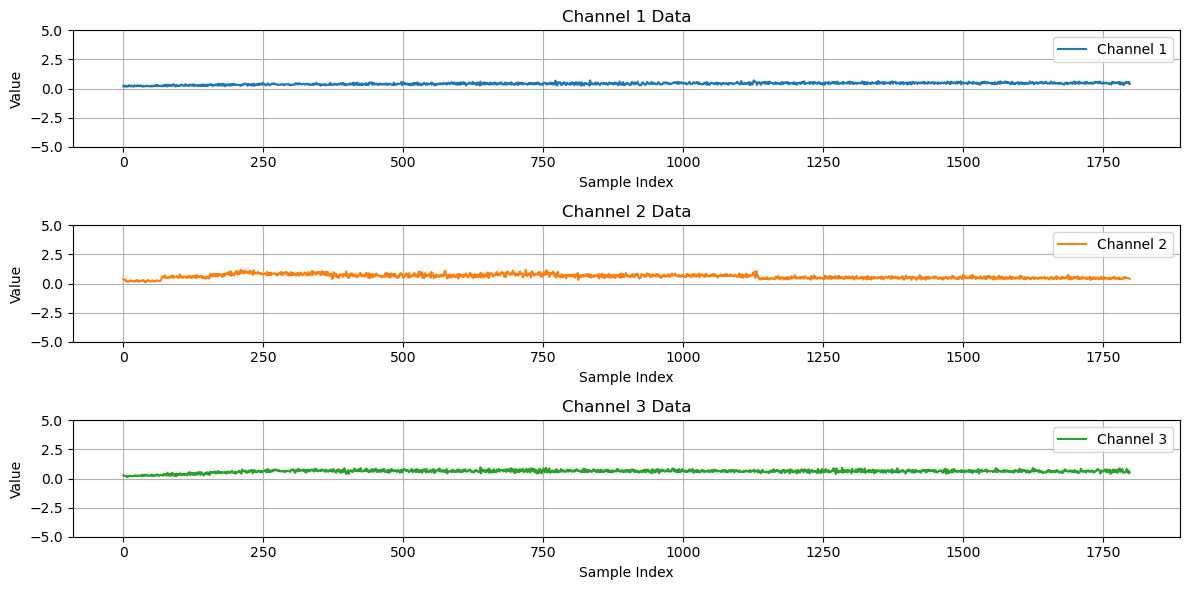

In [105]:
thresholds = []
for i in range(len(all_anomaly_test_data)):
    # print(all_anomaly_test_data[i].shape)
    # print(i)
    reconstructed_data = autoencoder.predict(all_anomaly_test_data[i])

    # print(reconstructed_data.shape)
    # print()
    reconstruction_error = np.mean(np.square(all_anomaly_test_data[i] - reconstructed_data), axis=1)
    # print(reconstruction_error.shape)
    # print()

    print(mean_error, std_error)
    print(np.isnan(reconstruction_error).any())  # True면 NaN이 포함되어 있음
    nan_count = np.sum(np.isnan(reconstruction_error))  # NaN의 개수
    print(f'NaN의 개수: {nan_count}')
    reconstruction_error = np.nan_to_num(reconstruction_error)

    # threshold
    # threshold = np.percentile(reconstruction_error, 65)  # 95번째 백분위수
    # thresholds.append(threshold)

    mean_error = np.mean(reconstruction_error)
    std_error = np.std(reconstruction_error)
    threshold = mean_error + 2 * std_error  # 예시: 평균 + 2 표준편차
    # print(threshold)
    is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
    is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
    is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축

    # 각 축 중 하나라도 True인 경우, 전체 데이터 포인트를 이상으로 판단
    is_anomaly = is_anomaly_x | is_anomaly_y | is_anomaly_z  # (1800,)
    # is_anomaly = is_anomaly_x 

    # print(is_anomaly.shape) 

    # is_anomaly = reconstruction_error > threshold
    # print(is_anomaly.shape)

    # unique, counts = np.unique(is_anomaly, return_counts=True)
    # print(unique, counts)

    # # 결과 출력
    # anomaly_count = counts[1] if True in unique else 0  # True의 개수
    # normal_count = counts[0] if False in unique else 0  # False의 개수

    # print(f'어노말리 개수: {anomaly_count}')
    # print(f'정상 개수: {normal_count}')
    
    anomaly_count = np.sum(is_anomaly)  # True의 개수
    normal_count = len(is_anomaly) - anomaly_count  # False의 개수

    # # 비율 계산
    total_count = len(is_anomaly)
    anomaly_ratio = anomaly_count / total_count
    normal_ratio = normal_count / total_count

    print(f'어노말리 비율: {anomaly_ratio:.2%}')
    print(f'정상 비율: {normal_ratio:.2%}')

    # print()
    # print(len(is_anomaly), anomaly_count, normal_count, len(all_anomaly_test_data[i]))

    print()

    plt.figure(figsize=(12, 6))

    # 각 채널에 대해 서브플롯 생성
    for i in range(3):
        plt.subplot(3, 1, i + 1)  # 3행 1열의 서브플롯 설정
        plt.plot(reconstruction_error[:, i], label=f'Channel {i + 1}', color=f'C{i}')  # 채널별 그래프
        plt.title(f'Channel {i + 1} Data')
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.legend()
        plt.ylim(-5, 5)
        plt.grid()

    plt.tight_layout()  # 서브플롯 간격 조정
    plt.show()

In [134]:
thresholds.sort()
thresholds

[3.832270737187668e-05,
 3.892730548185406e-05,
 4.2250423123683725e-05,
 4.767683198780388e-05,
 6.627507392953763e-05,
 6.721019841727373e-05,
 0.00010072665612422799,
 0.00042425265355872235,
 0.02995205702815639,
 0.03367608058045493]

In [123]:
threshold = thresholds[0]

In [128]:

for i in range(len(all_anomaly_test_data)):

    reconstructed_data = autoencoder.predict(all_anomaly_test_data[i])
    reconstruction_error = np.mean(np.square(all_anomaly_test_data[i] - reconstructed_data), axis=1)

    # nan 제거
    print(np.isnan(reconstruction_error).any())  # True면 NaN이 포함되어 있음
    nan_count = np.sum(np.isnan(reconstruction_error))  # NaN의 개수
    reconstruction_error = np.nan_to_num(reconstruction_error)

    threshold = np.percentile(reconstruction_error, 64)  # 95번째 백분위수
    is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
    is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
    is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축


    is_anomaly = is_anomaly_x | is_anomaly_y | is_anomaly_z  # (1800,)

    
    anomaly_count = np.sum(is_anomaly)  # True의 개수
    normal_count = len(is_anomaly) - anomaly_count  # False의 개수

    # # 비율 계산
    total_count = len(is_anomaly)
    anomaly_ratio = anomaly_count / total_count
    normal_ratio = normal_count / total_count

    print(f'어노말리 비율: {anomaly_ratio:.2%}')
    print(f'정상 비율: {normal_ratio:.2%}')
    print()

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

False
어노말리 비율: 84.21%
정상 비율: 15.79%

False
어노말리 비율: 78.43%
정상 비율: 21.57%

False
어노말리 비율: 100.00%
정상 비율: 0.00%

True
어노말리 비율: 99.94%
정상 비율: 0.06%



In [129]:
reconstructed_data = autoencoder.predict(x_test_concat)
reconstruction_error = np.mean(np.square(x_test_concat - reconstructed_data), axis=1)

is_anomaly_x = reconstruction_error[:, 0] > threshold  # x축
is_anomaly_y = reconstruction_error[:, 1] > threshold  # y축
is_anomaly_z = reconstruction_error[:, 2] > threshold  # z축

threshold = np.percentile(reconstruction_error, 64)  # 95번째 백분위수
is_anomaly = is_anomaly_x | is_anomaly_y | is_anomaly_z  # (1800,)


anomaly_count = np.sum(is_anomaly)  # True의 개수
normal_count = len(is_anomaly) - anomaly_count  # False의 개수

# 비율 계산
total_count = len(is_anomaly)
anomaly_ratio = anomaly_count / total_count
normal_ratio = normal_count / total_count

print(f'어노말리 비율: {anomaly_ratio:.2%}')
print(f'정상 비율: {normal_ratio:.2%}')

어노말리 비율: 99.54%
정상 비율: 0.46%
